# Where to view the August 12, 2026 total solar eclipse?

## Data Sources

Eclipse Path: http://xjubier.free.fr/en/site_pages/solar_eclipses/5MCSE/xSE_Five_Millennium_Canon.html \
Cloud Coverage: https://www.earthenv.org/cloud \
Light Pollution: https://djlorenz.github.io/astronomy/lp/ \
Transportation: https://centrodedescargas.cnig.es/CentroDescargas/buscadorCatalogo.do?codFamilia=REDTR

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import cartopy.io.img_tiles as cimgt
import geopandas as gpd

In [ ]:
spain_bbox = [-10, 5, 38, 44]
figsize = (15, 6)
osm = cimgt.OSM()

def min_max_scale(data: xr.DataArray) -> xr.DataArray:
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

### Cloud Coverage Data

In [3]:
cloud = xr.open_dataarray("data/MODCF_monthlymean_08.tif").squeeze()
cloud_spain = cloud.sel(x=slice(-10, 5), y=slice(44, 38))
cloud_spain

<xarray.DataArray 'band_data' (y: 720, x: 1800)> Size: 5MB
[1296000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 14kB -9.996 -9.988 -9.979 ... 4.979 4.987 4.996
  * y            (y) float64 6kB 44.0 43.99 43.98 43.97 ... 38.02 38.01 38.0
    spatial_ref  int64 8B ...
Attributes:
    TIFFTAG_DOCUMENTNAME:      Collection 5 Cloud Frequency
    TIFFTAG_IMAGEDESCRIPTION:  Monthly Cloud Frequency for 2000-2013 extracte...
    TIFFTAG_DATETIME:          2014
    TIFFTAG_ARTIST:            Adam M. Wilson (adam.wilson@yale.edu)
    AREA_OR_POINT:             Area

### Light Pollution Data

In [4]:
# The light pollution data set does not include any coordinate information.
# This is manually added after loading the file based on metadata from the data source. 
# Both the light pollution and the cloud coverage data sets use a WGS84 grid with 1/120 degree resolution
light = xr.open_dataarray("data/LightPollutionEurope2024.png").squeeze()
light["y"] = np.linspace(75, 34, 4920)
light["x"] = np.linspace(-32, 70, 12240)
light.rio.write_crs("EPSG:4326", inplace=True)
light_spain = light.sel(x=slice(-10, 5), y=slice(44, 38)).assign_coords(
    x=cloud_spain.x, # The light and cloud data sets use the same grid. Because of float differences we assign the coordinates of the other dataset to ensure they are exacly the same.
    y=cloud_spain.y, 
)
light_spain

/home/aleks/projects/eclipse/.venv/lib/python3.12/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray 'band_data' (y: 720, x: 1800)> Size: 5MB
[1296000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 14kB -9.996 -9.988 -9.979 ... 4.979 4.987 4.996
  * y            (y) float64 6kB 44.0 43.99 43.98 43.97 ... 38.02 38.01 38.0

### Elevation Data

In [5]:
elevation = xr.open_dataarray("data/output_hh.tif").squeeze()
elevation_spain = elevation.sel(x=slice(-10, 5), y=slice(44, 38))
elevation_spain = xr.where(elevation_spain > 0, 1, 0).coarsen(x=8, y=8, boundary="trim").sum()
land_mask = elevation_spain.rio.reproject_match(cloud_spain).assign_coords({
    "x": cloud_spain.x,
    "y": cloud_spain.y,
}) > 0
land_mask

<xarray.DataArray 'band_data' (y: 720, x: 1800)> Size: 1MB
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(720, 1800))
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * x            (x) float64 14kB -9.996 -9.988 -9.979 ... 4.979 4.987 4.996
  * y            (y) float64 6kB 44.0 43.99 43.98 43.97 ... 38.02 38.01 38.0

### Eclipse Path

In [6]:
umbral_path = gpd.read_file("data/eclipse_shadow/TSE 2026 August 12 Umbral Path.geojson")
umbral_path_polygon = umbral_path[umbral_path["Name"] == "Umbra"]
central_line = umbral_path[umbral_path["Name"] == "Central Line"]
lines = umbral_path[umbral_path["Name"].isin(["Umbra", "Central Line"])]

In [7]:
from scipy.spatial import KDTree
from pyproj import Transformer

central_line_projected = central_line.to_crs("EPSG:3035")
# Step 1: Extract coordinates from xarray raster
y = cloud_spain['y'].values
x = cloud_spain['x'].values
xx, yy = np.meshgrid(x, y)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)
x_proj, y_proj = transformer.transform(xx.ravel(), yy.ravel())
points = np.column_stack((x_proj, y_proj))

# Step 2: Sample the LineString geometry densely
line = central_line_projected.geometry.values[0]
num_points = 10000
sampled = [line.interpolate(t, normalized=True) for t in np.linspace(0, 1, num_points)]
line_coords = np.array([[pt.x, pt.y] for pt in sampled])

# Step 3: Build KDTree and query distances
tree = KDTree(line_coords)
distances, _ = tree.query(points)

# Step 4: Reshape to raster shape and wrap in DataArray
distance_raster = distances.reshape(xx.shape)
distance = xr.DataArray(
    distance_raster.astype(np.float32), 
    coords={"y": y, "x": cloud_spain['x'].values}, 
    dims=("y", "x"),
    name="distance",
)
distance.rio.write_crs("EPSG:4326", inplace=True)

<xarray.DataArray 'distance' (y: 720, x: 1800)> Size: 5MB
array([[142709.78 , 142262.33 , 141814.58 , ..., 532506.   , 532789.2  ,
        533072.44 ],
       [143387.39 , 142939.3  , 142492.72 , ..., 531669.94 , 531953.25 ,
        532236.7  ],
       [144064.2  , 143618.1  , 143172.84 , ..., 530834.1  , 531117.3  ,
        531400.6  ],
       ...,
       [662729.6  , 662330.   , 661930.4  , ...,  80546.63 ,  80308.89 ,
         80071.336],
       [663488.6  , 663089.   , 662689.2  , ...,  81414.04 ,  81175.74 ,
         80937.61 ],
       [664247.6  , 663847.8  , 663448.   , ...,  82282.04 ,  82043.7  ,
         81805.02 ]], shape=(720, 1800), dtype=float32)
Coordinates:
  * y            (y) float64 6kB 44.0 43.99 43.98 43.97 ... 38.02 38.01 38.0
  * x            (x) float64 14kB -9.996 -9.988 -9.979 ... 4.979 4.987 4.996
    spatial_ref  int64 8B 0

### Transportation Data

In [8]:
airports = gpd.read_file("data/transportation/rt_aerea.gpkg", layer="rt_aerodromo_p")
airports = airports[
    airports["t_aerodrod"].isin(["Aeródromo", "Aeródromo con helipuerto"])
]
airports = airports[airports["categoriad"] == "Internacional"]
airports = airports.to_crs("EPSG:3035")
airport_coords = [(p.x, p.y) for p in airports.geometry.values]
tree = KDTree(airport_coords)
aiport_distances, _ = tree.query(points)
aiport_distances_raster = aiport_distances.reshape(xx.shape)
aiport_distance = xr.DataArray(
    aiport_distances_raster.astype(np.float32),
    coords={"y": y, "x": x},
    dims=("y", "x"),
    name="aiport_distance",
)
aiport_distance.rio.write_crs("EPSG:4326", inplace=True)

<xarray.DataArray 'aiport_distance' (y: 720, x: 1800)> Size: 5MB
array([[152645.47, 152066.78, 151488.86, ..., 293905.03, 294324.  ,
        294743.94],
       [152173.14, 151592.64, 151012.89, ..., 293186.25, 293606.3 ,
        294027.34],
       [151705.02, 151122.7 , 150541.14, ..., 292468.62, 292889.78,
        293311.94],
       ...,
       [291870.8 , 291183.16, 290495.7 , ..., 214216.7 , 214446.92,
        214679.34],
       [292169.53, 291482.56, 290795.78, ..., 215091.81, 215321.16,
        215552.69],
       [292470.84, 291784.56, 291098.47, ..., 215967.3 , 216195.75,
        216426.39]], shape=(720, 1800), dtype=float32)
Coordinates:
  * y            (y) float64 6kB 44.0 43.99 43.98 43.97 ... 38.02 38.01 38.0
  * x            (x) float64 14kB -9.996 -9.988 -9.979 ... 4.979 4.987 4.996
    spatial_ref  int64 8B 0

In [9]:
cloud_spain_clipped = cloud_spain.rio.clip(umbral_path_polygon.geometry, umbral_path_polygon.crs, drop=True, all_touched=True)
light_spain_clipped = light_spain.rio.clip(umbral_path_polygon.geometry, umbral_path_polygon.crs, drop=True, all_touched=True)
distance_clipped = distance.rio.clip(umbral_path_polygon.geometry, umbral_path_polygon.crs, drop=True, all_touched=True)
aiport_distance_clipped = aiport_distance.rio.clip(umbral_path_polygon.geometry, umbral_path_polygon.crs, drop=True, all_touched=True)

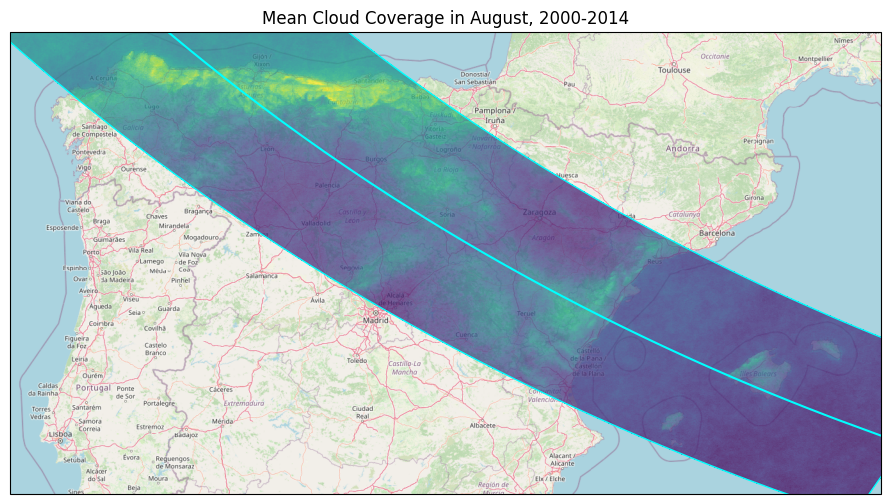

In [ ]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=osm.crs)
ax.set_extent(spain_bbox)
ax.add_image(osm, 7)
plt.pcolormesh(cloud_spain_clipped.x, cloud_spain_clipped.y, cloud_spain_clipped*0.01, alpha=0.75, transform=ccrs.PlateCarree())
lines.plot(ax=ax, facecolor="none", edgecolor="cyan", transform=ccrs.PlateCarree())
plt.title("Mean Cloud Coverage in August, 2000-2014")
plt.show()

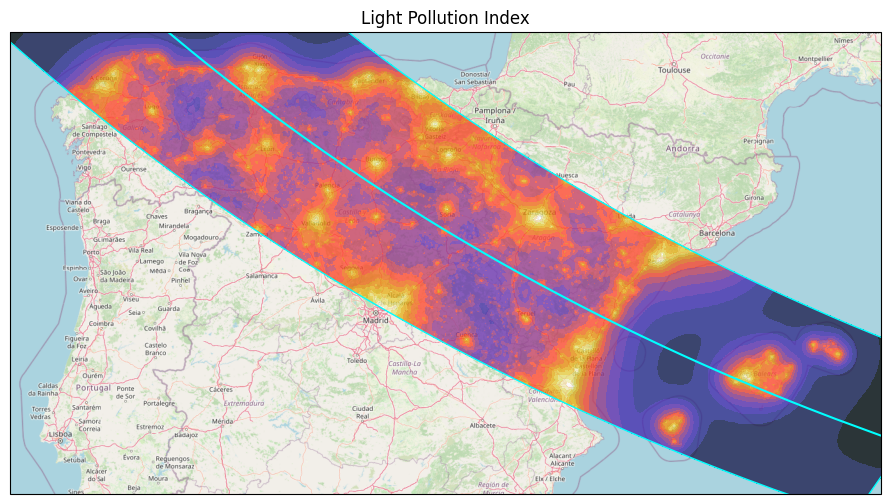

In [ ]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=osm.crs)
ax.set_extent(spain_bbox)
ax.add_image(osm, 7)
plt.pcolormesh(light_spain_clipped.x, light_spain_clipped.y, light_spain_clipped, alpha=0.75, transform=ccrs.PlateCarree(), cmap="CMRmap")
lines.plot(ax=ax, facecolor="none", edgecolor="cyan", transform=ccrs.PlateCarree())
plt.title("Light Pollution Index")
plt.show()

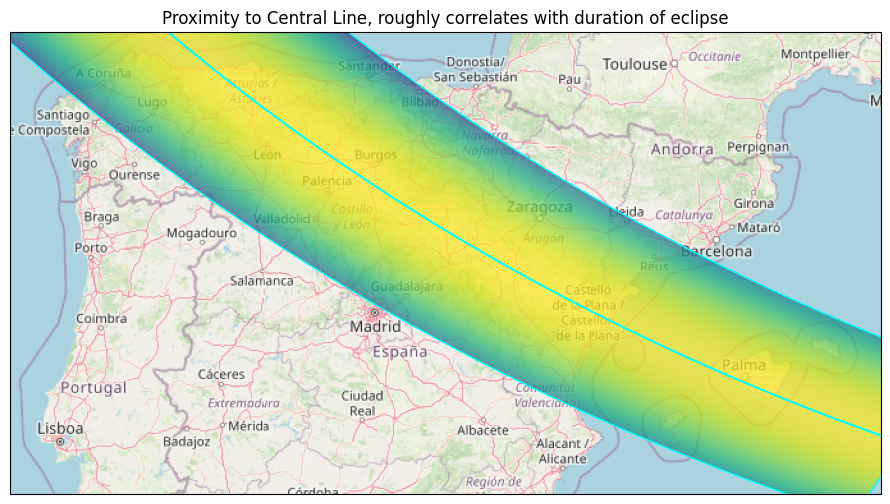

In [ ]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=osm.crs)
ax.set_extent(spain_bbox)
ax.add_image(osm, 6)
# plt.pcolormesh(distance_clipped.x, distance_clipped.y, distance_clipped, alpha=0.75, transform=ccrs.PlateCarree())
plt.pcolormesh(distance_clipped.x, distance_clipped.y, (1 - min_max_scale(distance_clipped)**2)**0.5, alpha=0.75, transform=ccrs.PlateCarree())
lines.plot(ax=ax, facecolor="none", edgecolor="cyan", transform=ccrs.PlateCarree())
plt.title("Proximity to Central Line, roughly correlates with duration of eclipse")
plt.show()

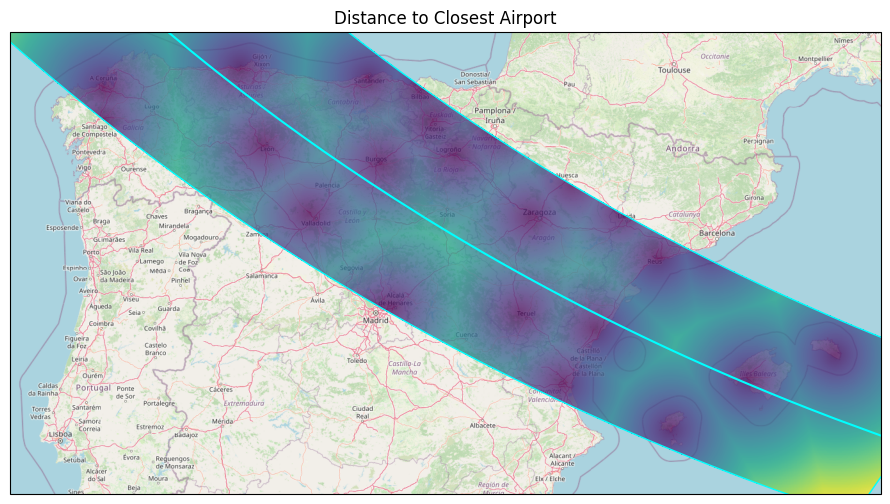

In [ ]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=osm.crs)
ax.set_extent(spain_bbox)
ax.add_image(osm, 7)
plt.pcolormesh(aiport_distance_clipped.x, aiport_distance_clipped.y, aiport_distance_clipped, alpha=0.75, transform=ccrs.PlateCarree())
lines.plot(ax=ax, facecolor="none", edgecolor="cyan", transform=ccrs.PlateCarree())
plt.title("Distance to Closest Airport")
plt.show()

## Eclipse Observability Score

In [14]:
eclipse_score = xr.Dataset({
    "cloud": cloud_spain_clipped,
    "light": light_spain_clipped,
    "totality": -(1 - min_max_scale(distance_clipped)**2)**0.5,
    "airport": aiport_distance_clipped,
}).where(land_mask)
eclipse_score

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 720, x: 1800)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 14kB -9.996 -9.988 -9.979 ... 4.979 4.987 4.996
  * y            (y) float64 6kB 44.0 43.99 43.98 43.97 ... 38.02 38.01 38.0
    spatial_ref  int64 8B 0
Data variables:
    cloud        (y, x) float32 5MB nan nan nan nan nan ... nan nan nan nan nan
    light        (y, x) float32 5MB nan nan nan nan nan ... nan nan nan nan nan
    totality     (y, x) float32 5MB nan nan nan nan nan ... nan nan nan nan nan
    airport      (y, x) float32 5MB nan nan nan nan nan ... nan nan nan nan nan

In [15]:
weights = {
    "cloud": 2,
    "light": 2,
    "totality": 2,
    "airport": 1,
}
eclipse_score["score"] = min_max_scale(
    sum(w * min_max_scale(eclipse_score[var_name]) for var_name, w in weights.items())
)

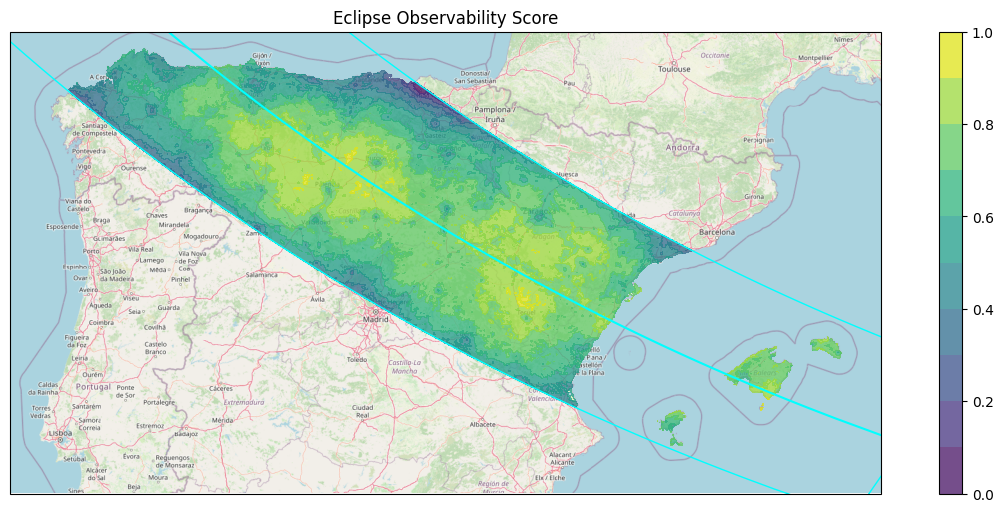

In [ ]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=osm.crs)
ax.set_extent(spain_bbox)
ax.add_image(osm, 7)
plt.contourf(
    eclipse_score.x,
    eclipse_score.y,
    1 - eclipse_score["score"],
    10,
    alpha=0.75,
    transform=ccrs.PlateCarree(),
)
lines.plot(ax=ax, facecolor="none", edgecolor="cyan", transform=ccrs.PlateCarree())
plt.title("Eclipse Observability Score")
plt.colorbar()
plt.show()